# Events Table Traditional - Rainfall

__Description__: 
Calculates events for NOAA Atlas 14 expected rainfall data
- Median rainfall value based on the NOAA Atlas 14 

This notebook sequentially calculates 
- Rainfall values and probability weights for different return period events
- Rainfall event probability weights
- Hyetograph information for several distributions
    - NRCS
    - NOAA Atlas 14
   

__Input__: 
- Parameters: the volume, region, and duration ([See map for volume and region](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html)).
        
- The area averaged precipitation frequency data for the specified duration.


__Output__: 1 JSON file with the NRCS and NOAA event hyetographs and 1 JSON file with event weights. Additionally 4 DSS files with the the NRCS and NOAA rainfall hyetograph information is prepared. Intermediate csv and excel files are saved for reference.


---
## Load Libraries, Parameters, and Data:
### Libraries:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import pathlib as pl
sys.path.append('..')
home = pl.Path(os.getcwd())
from src.core import *
import src.hydromet_JSON_to_DSS as hydromet_JSON_to_DSS

### Parameters: 
#### Local (site specific):

In [3]:
## Filenames and fields:
huc = '210200010203'               #  huc number or watershed ID (e.g. 071200040505)

In [4]:
Return_Intervals = events_initialize('NOAA') # enter FEMA if you want to include SID84 frequencies only
duration = 24  # [hours]; Event duration;  must be a duration in the input Precip_Table file
Time_Extend = 12.0 # Model run time extension beyond the hyetograph (24-hour) period.
hyet_duration = duration+Time_Extend
hydrology_IDs = ['NRCS', 'NOAAQ1', 'NOAAQ2', 'NOAAQ3', 'NOAAQ4']  # ID's of the different hydrology scenarios considered. 
Aerial_Reduction = 1.0 #only use for large watersheds

forcing_type = 'Rainfall'
noaa_data_crs = 4326 #Based on newer version of GeoPandas


In [5]:
## Filenames and paths:
precip_table = '{0}_PrecipTable.xlsx'.format(huc)  # NOAA Data
nrcs_precip_table = '{0}_nrcs_PrecipTable.xlsx'.format(huc)  # NRCS Data
atlas14_precip_table = '{0}_atlas_temporal_PrecipTable.xlsx'.format(huc)  # Atlas 14 Temporal Data

#Paths
datarepository_dir = home.parent/'DataRepository'
inputs_dir = home/'input'
outputs_dir = home/'output'
precip_table_dir = outputs_dir/precip_table
nrcs_precip_table_dir = outputs_dir/nrcs_precip_table   
atlas14_precip_table_dir = outputs_dir/atlas14_precip_table 
bin_dir = home.parent/'bin'

## Options:
display_print = False
save_dss = True
remove_ind_dur = True                              # Remove individual duration files which are combined at the end of this notebook
run_dur_dic = {'24': 2, '36.0': 2}  # Run durations in days

In [6]:
assert os.path.exists(str(outputs_dir/huc/'{0}_{1}.geojson'.format('huc',huc))), 'User needs to run HUC_Selection Notebook first'
hucs_gdf = gpd.read_file(outputs_dir/huc/'{0}_{1}.geojson'.format('huc',huc))

In [7]:
check_attributes(hucs_gdf)

hucs_gdf.head(1)

,objectid,tnmid,metasourceid,sourcedatadesc,sourceoriginator,sourcefeatureid,loaddate,referencegnis_ids,areaacres,areasqkm,...,name,hutype,humod,tohuc,noncontributingareaacres,noncontributingareasqkm,globalid,shape_Length,shape_Area,geometry
0,83880,{0DBB5F82-EA95-4EE3-8D88-DA4BE28373B2},{511D2AC8-11BA-45FC-AB98-F69D693D4C44},Watershed Boundary Dataset (WBD),Natural Resources and Conservation Service and...,None,1723704945000,None,4355.57,17.63,...,Southwestern St. John,I,NM,210200010300,0,0,{B9D6F5B7-E29C-11E2-8094-0021280458E6},36996.855567,1.966696e+07,"POLYGON ((-64.73866 18.34709, -64.73864 18.346..."


### Data:
#### NOAA Atlas 14 precipitation values:

,Median,Lower (90%),Upper (90%)
Tr,,,
2,4.321345,3.580341,5.235437
5,6.509532,5.347205,7.848213
10,8.381515,6.832847,10.070878
25,11.166331,8.954821,13.326769
50,13.551158,10.724163,16.132252
100,16.148982,12.631960,19.201905
200,19.022710,14.693500,22.640420
500,23.227046,17.611085,27.690883
1000,26.745037,19.995888,31.951161


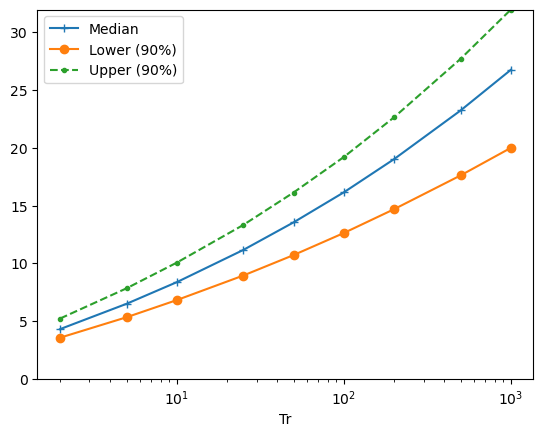

In [8]:
raw_precip = get_input_data(precip_table_dir, duration, Return_Intervals[0], display_print)
raw_precip.rename(columns = {'Expected Value': 'Median'}, inplace = True)
raw_precip.plot(style=['+-','o-','.--'], logx=True, ylim=(0, raw_precip['Upper (90%)'].max()))
raw_precip.head(10)

---
## NRCS

#### Rainfall Forcing Data:

In [9]:
hid = 0
## Reduce precipitation by aerial reduction factor:
raw_precip_reduced = raw_precip[raw_precip.select_dtypes(include=['number']).columns]*Aerial_Reduction

#events and precip curves
prep_curves, t_step = precip_distributed_nrcs(Return_Intervals,nrcs_precip_table_dir,
                     raw_precip_reduced)
final_curves = extend_time(prep_curves,Time_Extend,t_step)

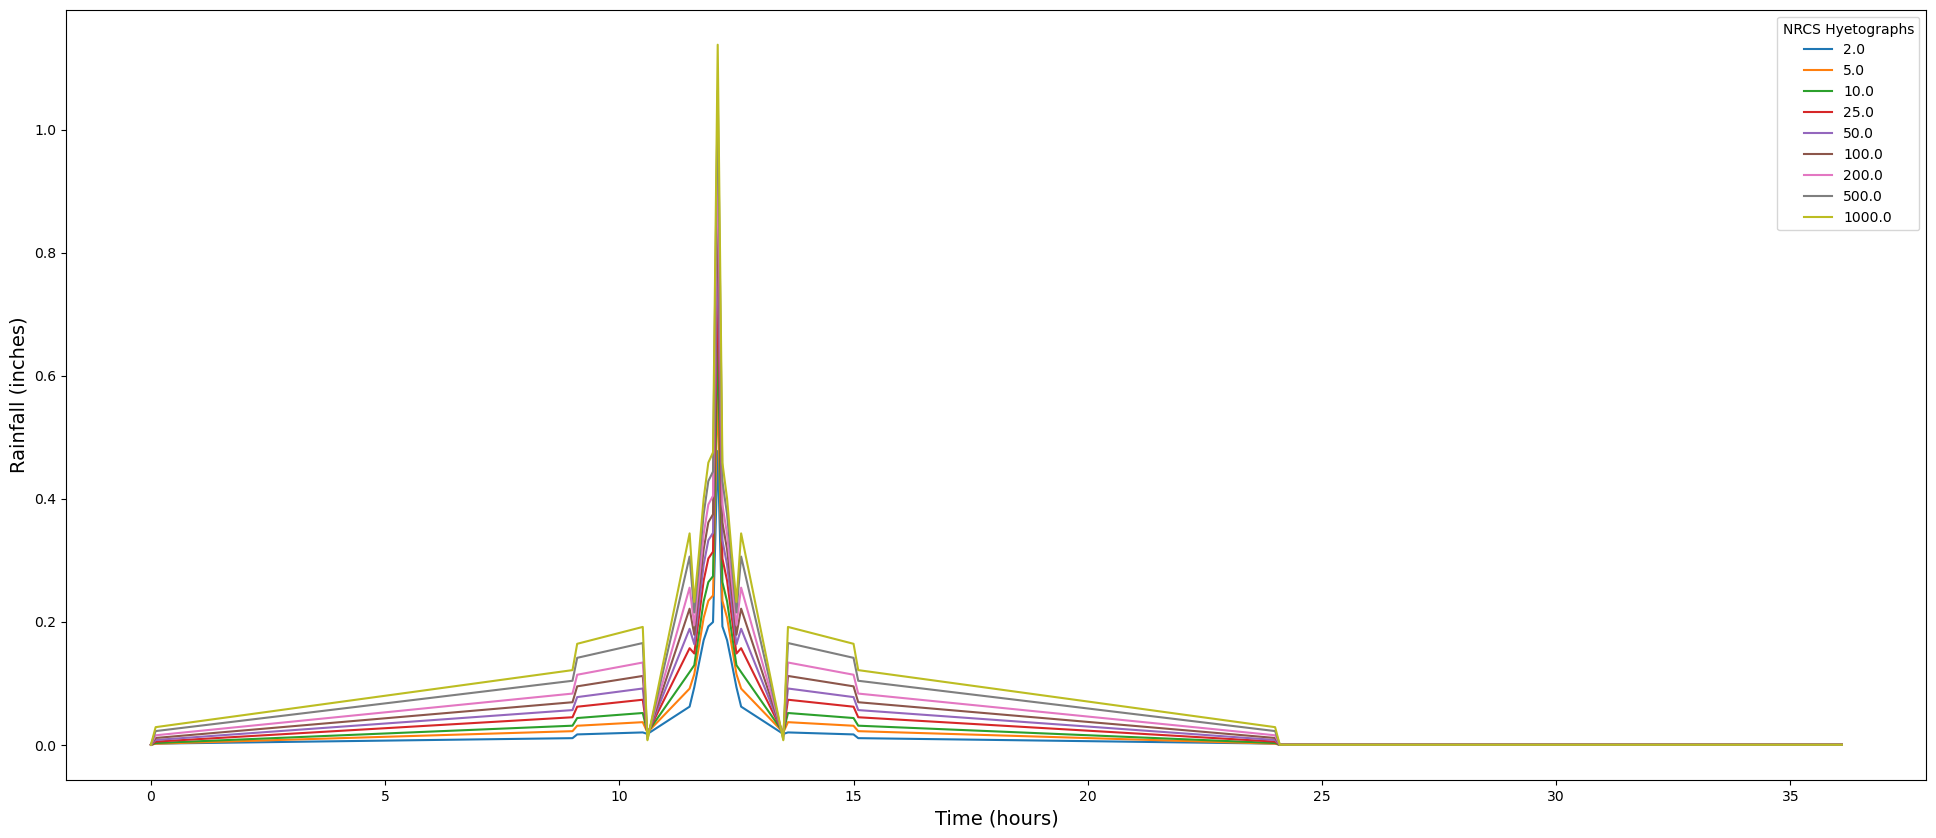

In [10]:
## test plot:
t_p = final_curves.plot(figsize=(24, 10))
t_p.legend(title='NRCS Hyetographs')
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Rainfall (inches)', fontsize=14)
t_p.plot();

#### Hydrology Weights:

In [11]:
#formatting
Event_Weights_Hydro = weights_noaa(Return_Intervals)

In [12]:
renamed_weights = {}
rename_map = {}

for k,v in zip(Return_Intervals,Event_Weights_Hydro):
    renamed_weights[hydrology_IDs[hid]+'_'+str(k)] = v
    rename_map[k] = hydrology_IDs[hid]+'_'+str(k)

In [13]:
renamed_curves = final_curves.rename(columns=rename_map).copy()
renamed_curves.index = renamed_curves.index.to_series().apply(lambda x: '%.1f' % x)
renamed_curves.head(2)

,NRCS_2,NRCS_5,NRCS_10,NRCS_25,NRCS_50,NRCS_100,NRCS_200,NRCS_500,NRCS_1000
hours,,,,,,,,,
0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
0.1,0.001801,0.001645,0.00275,0.005028,0.007695,0.010983,0.015333,0.022174,0.02856


In [14]:
#convert weighting table to pandas dataframe
df_renamed_weights = pd.DataFrame(data = {'Weight':list(renamed_weights.values())}, index = list(renamed_weights.keys())) 

### Save Data

##### To CSV:

In [15]:
renamed_curves.to_csv(outputs_dir/'Rainfall_{0}_Dur{1}_{2}.csv'.format(huc, duration,hydrology_IDs[hid]))
df_renamed_weights.to_csv(outputs_dir/'Weights_{0}_Dur{1}_{2}.csv'.format(huc, duration, hydrology_IDs[hid]))

In [16]:
#write events to excel for reference only
writer = pd.ExcelWriter(outputs_dir/'Rainfall_{0}_{1}.xlsx'.format(huc, hydrology_IDs[hid]))

for i, d in enumerate(rename_map.keys()):
    table = renamed_curves[rename_map[d]]
    table.to_excel(writer, sheet_name = 'ras_input_{0}-{1}'.format(d,rename_map[d]))
 
writer.close()

---
## NOAA

*Rainfall totals are the same as NRCS*

#### Quartile 1 Rainfall Forcing Data:

In [17]:
hid = 1
#events and precip curves
prep_curves, t_step = precip_distributed_atlas(Return_Intervals,atlas14_precip_table_dir,
                     raw_precip_reduced,hid)
final_curves = extend_time(prep_curves,Time_Extend,t_step)

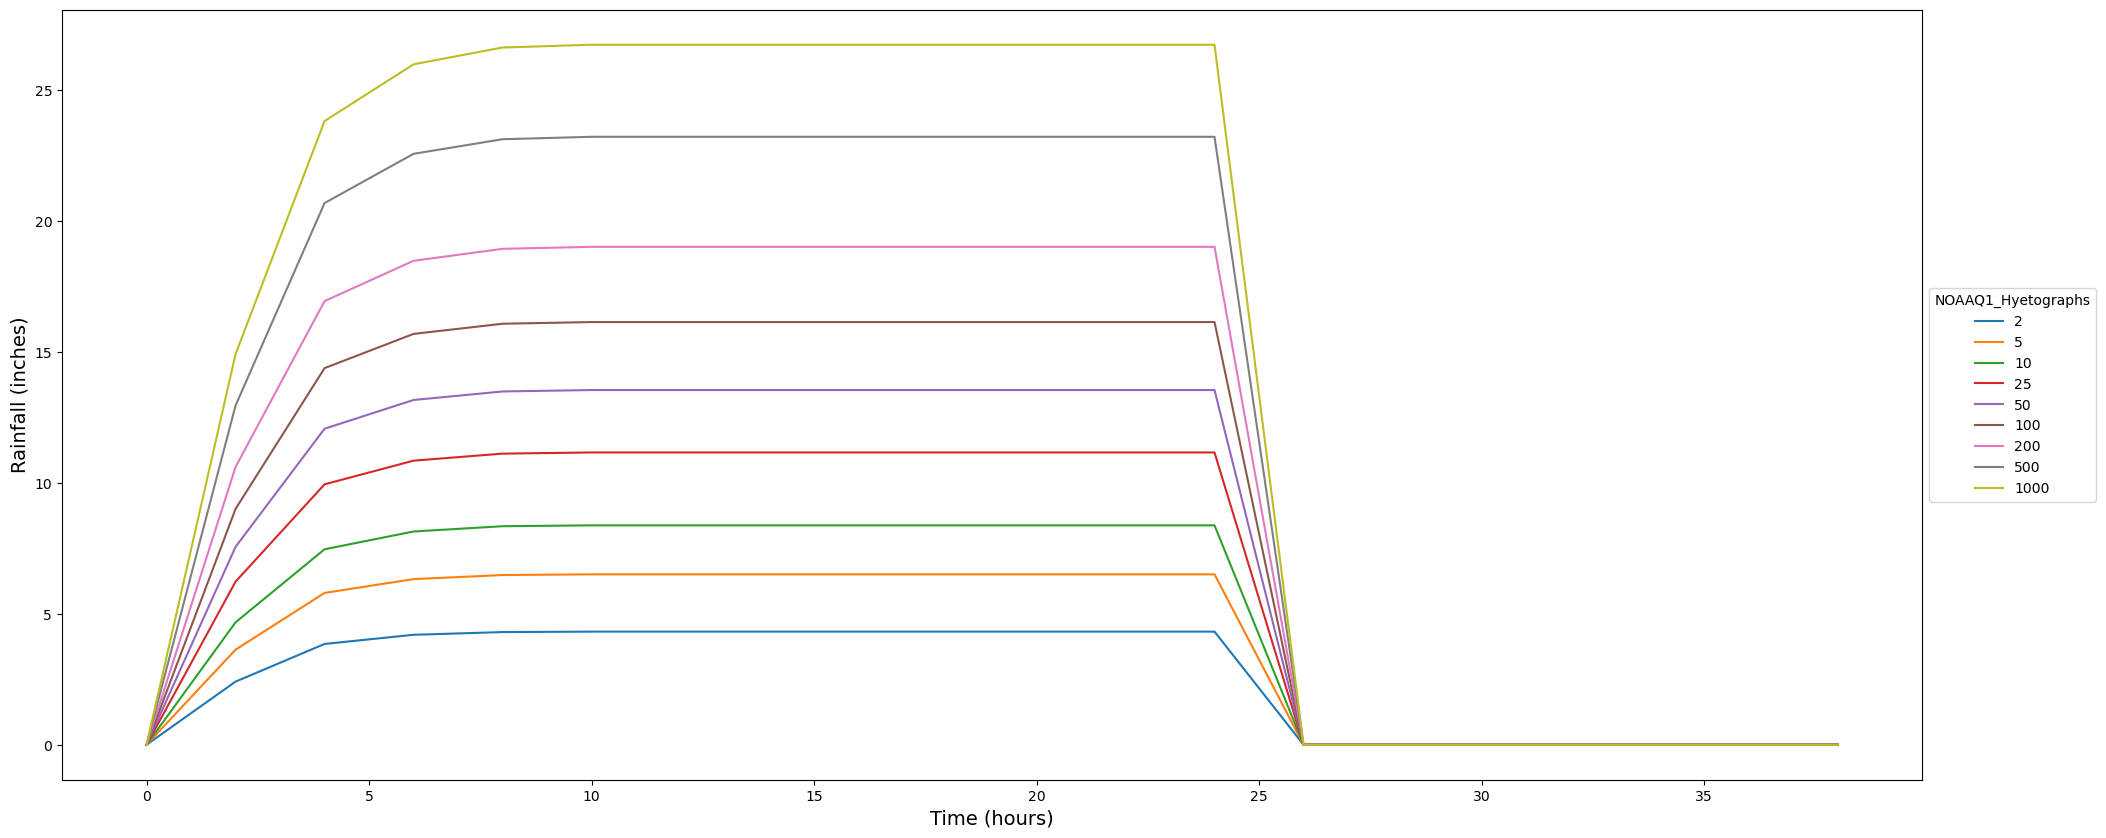

In [18]:
## graph
t_p = final_curves.plot(figsize=(24,10))
t_p.legend(title=hydrology_IDs[hid]+'_Hyetographs',loc='center left', bbox_to_anchor=(1.0, 0.5))
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Rainfall (inches)', fontsize=14)
t_p.plot();

In [19]:
#formatting
renamed_weights = {}
rename_map = {}

for k,v in zip(Return_Intervals,Event_Weights_Hydro):
    renamed_weights[hydrology_IDs[hid]+'_'+str(k)] = v
    rename_map[k] = hydrology_IDs[hid]+'_'+str(k)


renamed_curves = final_curves.rename(columns=rename_map).copy()
renamed_curves.index = renamed_curves.index.to_series().apply(lambda x: '%.1f' % x)

In [20]:
## Convert weighting table to pandas dataframe
df_renamed_weights = pd.DataFrame(data = {'Weight': list(renamed_weights.values())}, index = list(renamed_weights.keys())) 

### Save

##### To CSV:

In [21]:
renamed_curves.to_csv(outputs_dir/'Rainfall_{0}_Dur{1}_{2}.csv'.format(huc, duration,hydrology_IDs[hid]))
df_renamed_weights.to_csv(outputs_dir/'Weights_{0}_Dur{1}_{2}.csv'.format(huc, duration, hydrology_IDs[hid]))

In [22]:
#write events to excel for reference only
writer = pd.ExcelWriter(outputs_dir/'Rainfall_{0}_{1}.xlsx'.format(huc, hydrology_IDs[hid]))

for i, d in enumerate(rename_map.keys()):
    table = renamed_curves[rename_map[d]]
    table.to_excel(writer, sheet_name = 'ras_input_{0}-{1}'.format(d,rename_map[d]))
 
writer.close()

#### Quartile 2 Rainfall Forcing Data:

In [23]:
hid = 2
#events and precip curves
prep_curves, t_step = precip_distributed_atlas(Return_Intervals,atlas14_precip_table_dir,
                     raw_precip_reduced,hid)
final_curves = extend_time(prep_curves,Time_Extend,t_step)

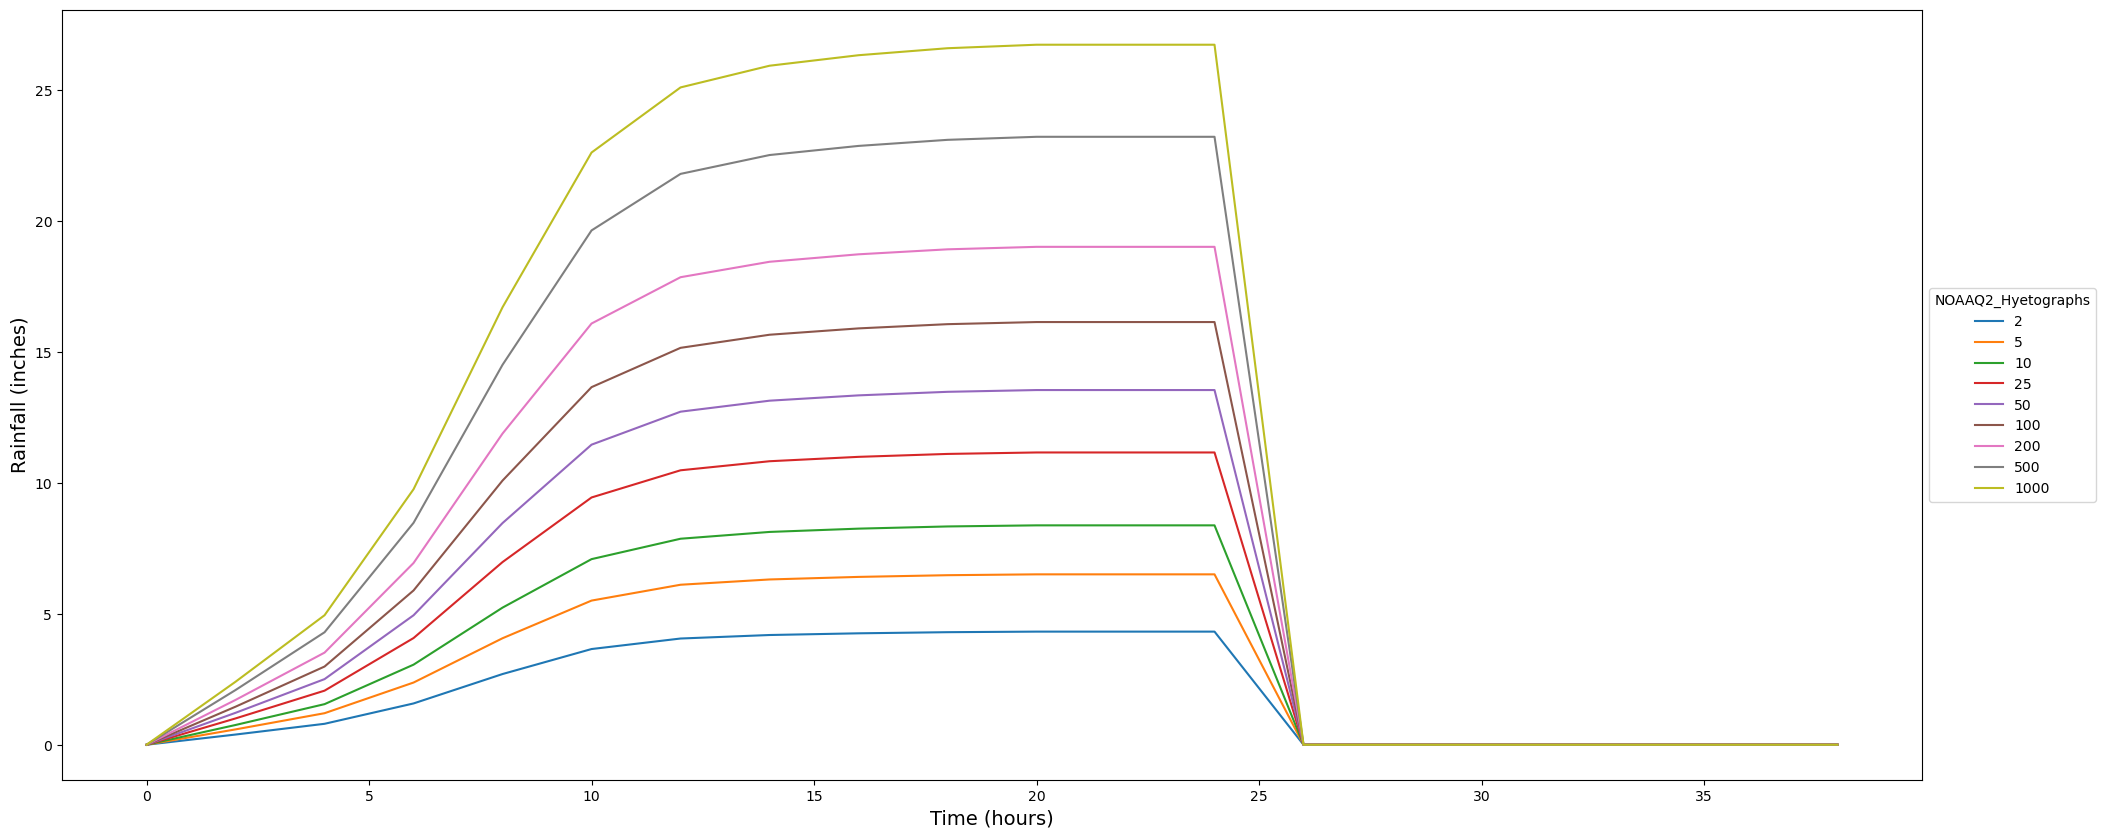

In [24]:
## graph
t_p = final_curves.plot(figsize=(24,10))
t_p.legend(title=hydrology_IDs[hid]+'_Hyetographs',loc='center left', bbox_to_anchor=(1.0, 0.5))
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Rainfall (inches)', fontsize=14)
t_p.plot();

In [25]:
#formatting
renamed_weights = {}
rename_map = {}

for k,v in zip(Return_Intervals,Event_Weights_Hydro):
    renamed_weights[hydrology_IDs[hid]+'_'+str(k)] = v
    rename_map[k] = hydrology_IDs[hid]+'_'+str(k)


renamed_curves = final_curves.rename(columns=rename_map).copy()
renamed_curves.index = renamed_curves.index.to_series().apply(lambda x: '%.1f' % x)

In [26]:
## Convert weighting table to pandas dataframe
df_renamed_weights = pd.DataFrame(data = {'Weight': list(renamed_weights.values())}, index = list(renamed_weights.keys())) 

### Save

##### To CSV:

In [27]:
renamed_curves.to_csv(outputs_dir/'Rainfall_{0}_Dur{1}_{2}.csv'.format(huc, duration,hydrology_IDs[hid]))
df_renamed_weights.to_csv(outputs_dir/'Weights_{0}_Dur{1}_{2}.csv'.format(huc, duration, hydrology_IDs[hid]))

In [28]:
#write events to excel for reference only
writer = pd.ExcelWriter(outputs_dir/'Rainfall_{0}_{1}.xlsx'.format(huc, hydrology_IDs[hid]))

for i, d in enumerate(rename_map.keys()):
    table = renamed_curves[rename_map[d]]
    table.to_excel(writer, sheet_name = 'ras_input_{0}-{1}'.format(d,rename_map[d]))
 
writer.close()

#### Quartile 3 Rainfall Forcing Data:

In [29]:
hid = 3
#events and precip curves
prep_curves, t_step = precip_distributed_atlas(Return_Intervals,atlas14_precip_table_dir,
                     raw_precip_reduced,hid)
final_curves = extend_time(prep_curves,Time_Extend,t_step)

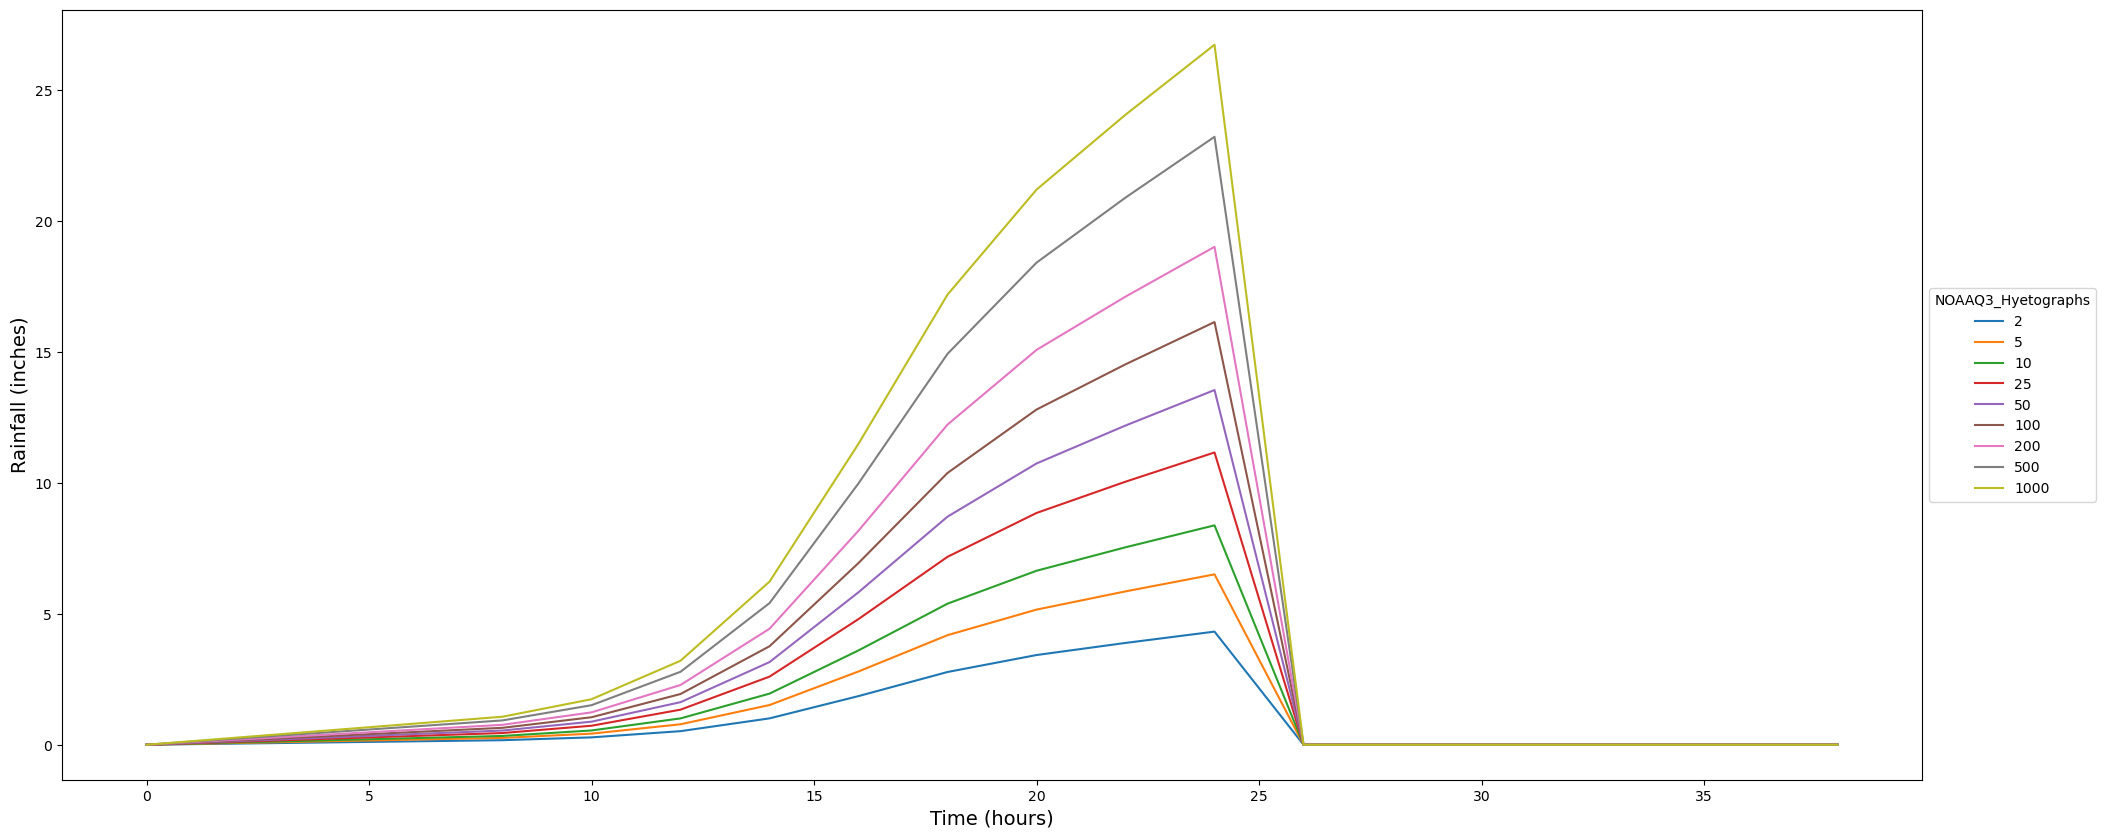

In [30]:
## graph
t_p = final_curves.plot(figsize=(24,10))
t_p.legend(title=hydrology_IDs[hid]+'_Hyetographs',loc='center left', bbox_to_anchor=(1.0, 0.5))
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Rainfall (inches)', fontsize=14)
t_p.plot();

In [31]:
#formatting
renamed_weights = {}
rename_map = {}

for k,v in zip(Return_Intervals,Event_Weights_Hydro):
    renamed_weights[hydrology_IDs[hid]+'_'+str(k)] = v
    rename_map[k] = hydrology_IDs[hid]+'_'+str(k)


renamed_curves = final_curves.rename(columns=rename_map).copy()
renamed_curves.index = renamed_curves.index.to_series().apply(lambda x: '%.1f' % x)

In [32]:
## Convert weighting table to pandas dataframe
df_renamed_weights = pd.DataFrame(data = {'Weight': list(renamed_weights.values())}, index = list(renamed_weights.keys())) 

### Save

##### To CSV:

In [33]:
renamed_curves.to_csv(outputs_dir/'Rainfall_{0}_Dur{1}_{2}.csv'.format(huc, duration,hydrology_IDs[hid]))
df_renamed_weights.to_csv(outputs_dir/'Weights_{0}_Dur{1}_{2}.csv'.format(huc, duration, hydrology_IDs[hid]))

In [34]:
#write events to excel for reference only
writer = pd.ExcelWriter(outputs_dir/'Rainfall_{0}_{1}.xlsx'.format( huc, hydrology_IDs[hid]))

for i, d in enumerate(rename_map.keys()):
    table = renamed_curves[rename_map[d]]
    table.to_excel(writer, sheet_name = 'ras_input_{0}-{1}'.format(d,rename_map[d]))
 
writer.close()

#### Quartile 4 Rainfall Forcing Data:

In [35]:
hid = 4
#events and precip curves
prep_curves, t_step = precip_distributed_atlas(Return_Intervals,atlas14_precip_table_dir,
                     raw_precip_reduced,hid)
final_curves = extend_time(prep_curves,Time_Extend,t_step)

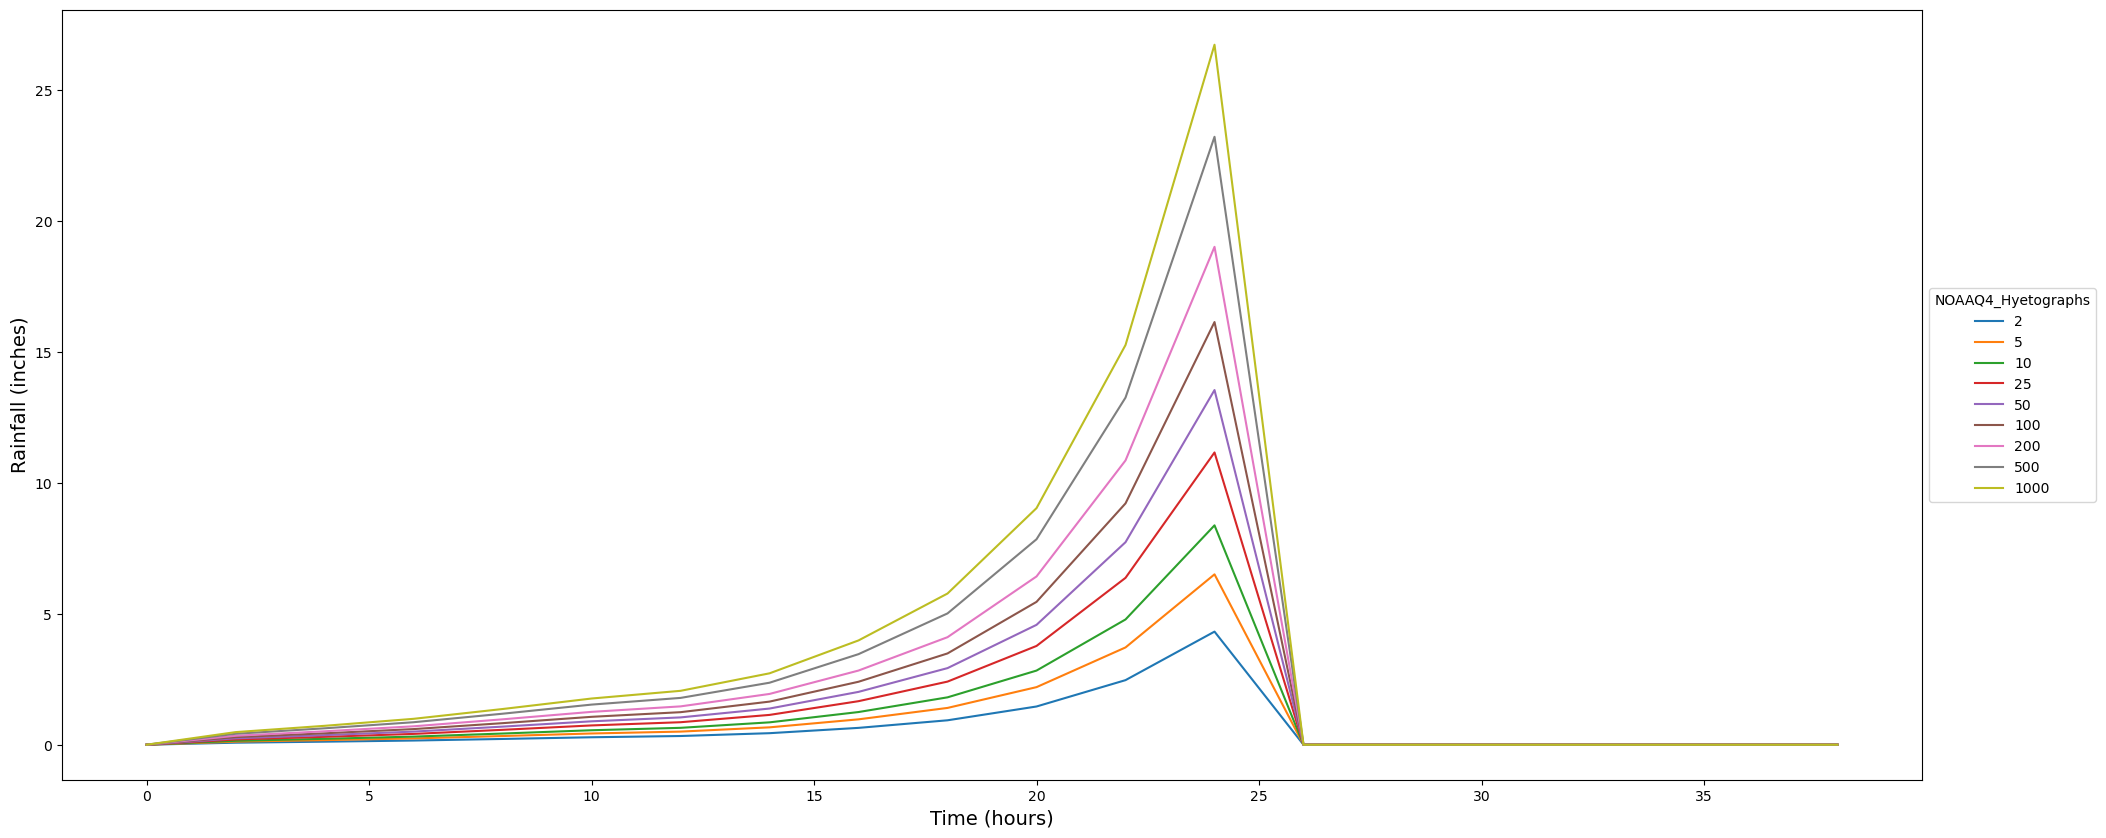

In [36]:
## graph
t_p = final_curves.plot(figsize=(24,10))
t_p.legend(title=hydrology_IDs[hid]+'_Hyetographs',loc='center left', bbox_to_anchor=(1.0, 0.5))
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Rainfall (inches)', fontsize=14)
t_p.plot();

In [37]:
#formatting
renamed_weights = {}
rename_map = {}

for k,v in zip(Return_Intervals,Event_Weights_Hydro):
    renamed_weights[hydrology_IDs[hid]+'_'+str(k)] = v
    rename_map[k] = hydrology_IDs[hid]+'_'+str(k)


renamed_curves = final_curves.rename(columns=rename_map).copy()
renamed_curves.index = renamed_curves.index.to_series().apply(lambda x: '%.1f' % x)

In [38]:
## Convert weighting table to pandas dataframe
df_renamed_weights = pd.DataFrame(data = {'Weight': list(renamed_weights.values())}, index = list(renamed_weights.keys())) 

### Save

##### To CSV:

In [39]:
renamed_curves.to_csv(outputs_dir/'Rainfall_{0}_Dur{1}_{2}.csv'.format(huc, duration,hydrology_IDs[hid]))
df_renamed_weights.to_csv(outputs_dir/'Weights_{0}_Dur{1}_{2}.csv'.format(huc, duration, hydrology_IDs[hid]))

In [40]:
#write events to excel for reference only
writer = pd.ExcelWriter(outputs_dir/'Rainfall_{0}_{1}.xlsx'.format(huc, hydrology_IDs[hid]))

for i, d in enumerate(rename_map.keys()):
    table = renamed_curves[rename_map[d]]
    table.to_excel(writer, sheet_name = 'ras_input_{0}-{1}'.format(d,rename_map[d]))
 
writer.close()

## Save Outputs to JSON and DSS

### Rainfall Forcing Data

In [41]:
rainfall_dic = combine_results_stratified(forcing_type, outputs_dir, huc, duration, hydrology_IDs, run_dur_dic, remove_ind_dur=True)

with open(outputs_dir/'{0}_{1}.json'.format(huc, forcing_type), 'w') as f:
    json.dump(rainfall_dic, f)
    
forcing = '{0}_{1}'.format(huc,forcing_type)
jsonname = '{0}_{1}.json'.format(huc, forcing_type)

In [42]:
hydromet_JSON_to_DSS.main(outputs_dir, outputs_dir, bin_dir, forcing, jsonname, variable = 'Rainfall',data_type = 'PER-CUM')

Converting 210200010203_Rainfall.json to DSS...
Dss File written to c:\git\hydromet\notebooks\output\210200010203_Rainfall_NRCS.dss
Dss File written to c:\git\hydromet\notebooks\output\210200010203_Rainfall_NOAAQ1.dss
Dss File written to c:\git\hydromet\notebooks\output\210200010203_Rainfall_NOAAQ2.dss
Dss File written to c:\git\hydromet\notebooks\output\210200010203_Rainfall_NOAAQ3.dss
Dss File written to c:\git\hydromet\notebooks\output\210200010203_Rainfall_NOAAQ4.dss


### Weights

In [44]:
weights_dic = combine_results_traditional('Weights',  outputs_dir, huc, duration, hydrology_IDs, run_dur_dic, remove_ind_dur=False)

with open(outputs_dir/'{0}_Weights.json'.format(huc), 'w') as f:
    json.dump(weights_dic, f)

---
# End